In [1]:
import os
import PIL
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models

In [2]:
data_dir = ".\onepiece_images"
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.png')))
print("Image count: ", image_count)

Image count:  621


In [3]:
np.random.seed(1)
tf.random.set_seed(1)

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.set_visible_devices([gpus[0]],"GPU")

## Image Data Preprocessing

### 1. Load the data

In [4]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

print()

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 621 files belonging to 7 classes.
Using 497 files for training.

Found 621 files belonging to 7 classes.
Using 124 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['lufei', 'luobin', 'namei', 'qiaoba', 'shanzhi', 'suolong', 'wusuopu']


### 2. Data Visualization

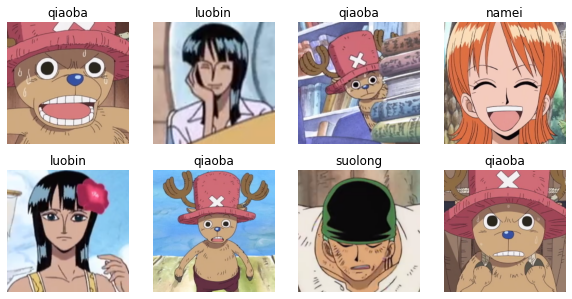

In [6]:
plt.figure(figsize=(10, 5))

for images, labels in train_ds.take(1):
    for i in range(8):
        
        ax = plt.subplot(2, 4, i + 1)  

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        
        plt.axis("off")

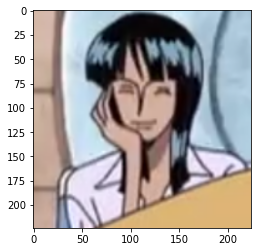

In [7]:
plt.imshow(images[1].numpy().astype("uint8"))

### 3. Recheck the data

In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


### 4. Configure and preprocess the dataset

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalization_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


image_batch, labels_batch = next(iter(val_ds))
first_image = image_batch[0]

np.min(first_image), np.max(first_image)

(0.0, 0.9928046)

### 6. Build the model

In [11]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

def VGG16(nb_classes, input_shape):
    input_tensor = Input(shape=input_shape)
    # 1st block
    x = Conv2D(64, (3,3), activation='relu', padding='same',name='block1_conv1')(input_tensor)
    x = Conv2D(64, (3,3), activation='relu', padding='same',name='block1_conv2')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block1_pool')(x)
    # 2nd block
    x = Conv2D(128, (3,3), activation='relu', padding='same',name='block2_conv1')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same',name='block2_conv2')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block2_pool')(x)
    # 3rd block
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='block3_conv1')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='block3_conv2')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='block3_conv3')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block3_pool')(x)
    # 4th block
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block4_conv1')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block4_conv2')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block4_conv3')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block4_pool')(x)
    # 5th block
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block5_conv1')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block5_conv2')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block5_conv3')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block5_pool')(x)
    # full connection
    x = Flatten()(x)
    x = Dense(4096, activation='relu',  name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    output_tensor = Dense(nb_classes, activation='softmax', name='predictions')(x)

    model = Model(input_tensor, output_tensor)
    return model

model=VGG16(1000, (img_width, img_height, 3))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [13]:
epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20


C:\Users\jason\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


16/16 [==============================] - 251s 16s/step - loss: 3.4537 - accuracy: 0.1529 - val_loss: 6.8379 - val_accuracy: 0.1129
Epoch 2/20
16/16 [==============================] - 250s 16s/step - loss: 2.0254 - accuracy: 0.1368 - val_loss: 6.7926 - val_accuracy: 0.1935
Epoch 3/20
16/16 [==============================] - 250s 16s/step - loss: 1.7130 - accuracy: 0.3803 - val_loss: 6.7851 - val_accuracy: 0.2500
Epoch 4/20
16/16 [==============================] - 241s 15s/step - loss: 1.0449 - accuracy: 0.6318 - val_loss: 6.7660 - val_accuracy: 0.5645
Epoch 5/20
16/16 [==============================] - 241s 15s/step - loss: 0.6085 - accuracy: 0.7887 - val_loss: 6.7586 - val_accuracy: 0.6129
Epoch 6/20
16/16 [==============================] - 239s 15s/step - loss: 0.3432 - accuracy: 0.8853 - val_loss: 6.6893 - val_accuracy: 0.7016
Epoch 7/20
16/16 [==============================] - 238s 15s/step - loss: 0.5103 - accuracy: 0.8350 - val_loss: 6.7621 - val_accuracy: 0.4839
Epoch 8/20
16/16 

## Evaluate the model

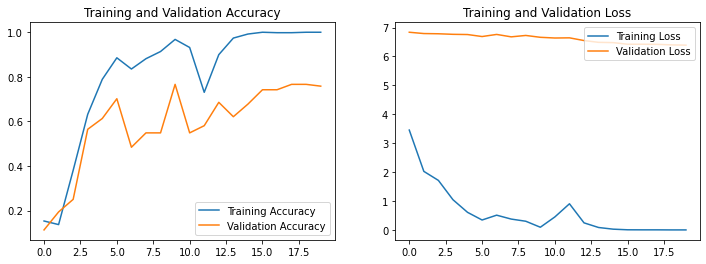

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
# model.predict("luffy_test.png")